In [7]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import AutoModelForSequenceClassification, AutoTokenizer, AutoConfig
import torch

sns.set_theme()

os.environ['TOKENIZERS_PARALLELISM'] = 'true'

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")


def init_model(model_path: str):
    tokenizer = AutoTokenizer.from_pretrained(model_path, use_fast=True)
    config = AutoConfig.from_pretrained(model_path)
    model = AutoModelForSequenceClassification.from_pretrained(model_path).to(device)

    return (tokenizer, config, model)

In [8]:
import pandas as pd

file_path = "../data/1comments.h5"
df = pd.read_hdf(file_path, key='df')
df.sample(3)

,id,createdAt,userId,userCreatedAt,classYear,universityId,country,universityName,parentId,questionId,comment,review,chapter_explanation_update,question_update,question_explanation_update,qc_explanation_update
18184,23224,2023-05-02 15:30:00.175530+00:00,18597,2022-03-12 17:12:53.159916+00:00,Year 3,2697,United Kingdom,St. George's University (SGUL),NaN,4914,In practise of course it's up to the patient a...,False,None,None,None,None
7225,10294,2022-05-01 13:42:13.508654+00:00,16877,2022-01-28 14:40:48.931000+00:00,Year 3,2558,United Kingdom,Imperial College School of Medicine,NaN,5611,pain,True,None,None,None,None
2328,3625,2021-06-17 15:29:59.457000+00:00,8217,2021-05-06 18:32:11.763000+00:00,Year 3,2688,United Kingdom,University of Warwick,2621.0,4048,should have spent more time on trivago,False,None,None,None,None


In [43]:
from datasets import Dataset

def dataloader(ds: Dataset):
  for item in ds:
    yield item['text']

ds = Dataset.from_dict({'text': df['comment']})

# Tone analysis

Checking the tone of submissions

In [11]:
tone_ckpt = "cardiffnlp/twitter-roberta-base-sentiment-latest"

In [12]:
tone_tokenizer, tone_config, tone_model = init_model(tone_ckpt)


Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [26]:
from transformers import pipeline
from tqdm import tqdm

tone_pipe = pipeline("sentiment-analysis", 
  model=tone_model, 
  device=device,
  tokenizer=tone_tokenizer,
  max_length=512, 
  truncation=True
)

tone_labels = ['neutral', 'negative', 'positive']

tone_pipe('Cases of Covid are rising!', top_k=len(tone_labels), batch_size=64)

[{'label': 'negative', 'score': 0.7387604713439941},
 {'label': 'neutral', 'score': 0.2311086803674698},
 {'label': 'positive', 'score': 0.03013083152472973}]

In [ ]:
res_emotion = []
for res in tqdm(tone_pipe(dataloader(ds), top_k=len(tone_labels), batch_size=64), total=ds.num_rows):
  res_sorted = sorted(res, key=lambda x: x['label'])
  res_emotion.append([x['score'] for x in res_sorted])

df = df.join(pd.DataFrame(res_emotion, columns=tone_labels))

In [ ]:
df['tone'] = df[tone_labels].idxmax(axis=1)

In [17]:
df.to_hdf('../data/2comments.h5', key='df', mode='w')
# df = pd.read_hdf('../data/2comments.h5', key='df')

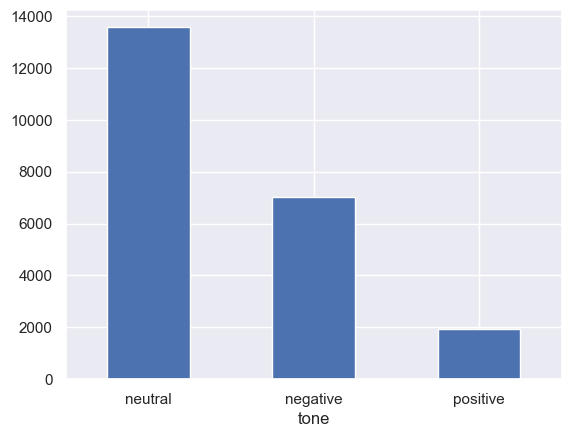

In [21]:
fig, ax = plt.subplots()
ax = df['tone'].value_counts().plot(kind='bar')
plt.xticks(rotation=0, ha='center')
plt.show()

# Emotion Analysis

Checking the emotion of submissions

In [36]:
emotion_chkp = "bhadresh-savani/distilbert-base-uncased-emotion"
emotion_tokenizer, emotion_config, emotion_model = init_model(emotion_chkp)


In [41]:
emotion_pipe = pipeline("zero-shot-classification", 
  model=emotion_model,
  tokenizer=emotion_tokenizer,
  device=device,
  max_length=512,
  truncation=True
)

emotion_labels = ['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']

emotion_pipe('Cases of Covid are rising!', 
             top_k=len(emotion_labels), 
             candidate_labels=emotion_labels
             )

Failed to determine 'entailment' label id from the label2id mapping in the model config. Setting to -1. Define a descriptive label2id mapping in the model config to ensure correct outputs.


{'sequence': 'Cases of Covid are rising!',
 'labels': ['surprise', 'joy', 'fear', 'love', 'anger', 'sadness'],
 'scores': [0.8994591236114502,
  0.03682132437825203,
  0.02006826549768448,
  0.017188696190714836,
  0.015889901667833328,
  0.010572700761258602]}

In [ ]:
res_emotion = []
for res in tqdm(emotion_pipe(dataloader(ds), top_k=len(emotion_labels), batch_size=64, candidate_labels=emotion_labels), total=ds.num_rows):
  res_list = []
  for label, score in zip(res['labels'], res['scores']):
    res_list.append({'label': label, 'score': score})
  res_sorted = sorted(res_list, key=lambda x: x['label'])
  res_emotion.append([x['score'] for x in res_sorted])

df = df.join(pd.DataFrame(res_emotion, columns=emotion_labels))

In [35]:
df['emotion'] = df[emotion_labels].idxmax(axis=1)

In [56]:
df.to_hdf('../data/3comments.h5', key='df', mode='w')
# df = pd.read_hdf('../data/3comments.h5', key='df')

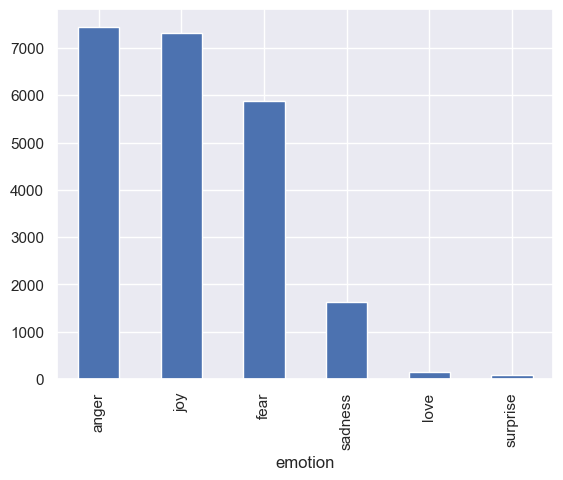

In [57]:
fig, ax = plt.subplots()
ax = df['emotion'].value_counts().plot(kind='bar')

plt.show()

# Zero-shot classification

Classification of submissions based on certain categories

In [64]:
from transformers import AutoModelForSequenceClassification

theme_chkp = "facebook/bart-large-mnli"
theme_tokenizer, _, _ = init_model(theme_chkp)

theme_labels = ['educational', 'giving feedback', 'asking a question', 'insulting', 'supporting']

id2label = {i: k for i, k in enumerate(theme_labels)}
label2id = {k: i for i, k in enumerate(theme_labels)}

theme_model = AutoModelForSequenceClassification.from_pretrained(theme_chkp,
  num_labels=len(theme_labels),
  id2label=id2label,
  label2id=label2id,
  ignore_mismatched_sizes=True
)

theme_pipe = pipeline("zero-shot-classification", 
  model=theme_model,
  tokenizer=theme_tokenizer,
  device=device,
  max_length=512,
  truncation=True
)

def theme_analysis(text: str, multi_label=False):
  res = theme_pipe(text, theme_labels, multi_label=multi_label)

  output = {k: 0.0 for k in theme_labels}

  for k, score in zip(res['labels'], res['scores']):
      output[k] = score
  
  return output

theme_analysis("Covid cases are increasing fast!")

Some weights of BartForSequenceClassification were not initialized from the model checkpoint at facebook/bart-large-mnli and are newly initialized because the shapes did not match:
- classification_head.out_proj.bias: found shape torch.Size([3]) in the checkpoint and torch.Size([5]) in the model instantiated
- classification_head.out_proj.weight: found shape torch.Size([3, 1024]) in the checkpoint and torch.Size([5, 1024]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Failed to determine 'entailment' label id from the label2id mapping in the model config. Setting to -1. Define a descriptive label2id mapping in the model config to ensure correct outputs.


{'educational': 0.2142215371131897,
 'giving feedback': 0.1849270462989807,
 'asking a question': 0.27699366211891174,
 'insulting': 0.16431444883346558,
 'supporting': 0.15954318642616272}

In [40]:
for k in theme_labels:
    df[k] = 0.0

In [41]:
for id in tqdm(df.index):
    selftext = df.at[id, 'comment']
    if len(selftext) == 0:
        continue
    output = theme_analysis(selftext)
    for k in theme_labels:
        df.at[id, k] = output[k]

100%|██████████| 22514/22514 [5:54:48<00:00,  1.06it/s]    


In [42]:
df['theme'] = df[theme_labels].idxmax(axis=1)

In [65]:
df.to_hdf('../data/4comments.h5', key='df', mode='w')
# df = pd.read_hdf('../data/4comments.h5', key='df')

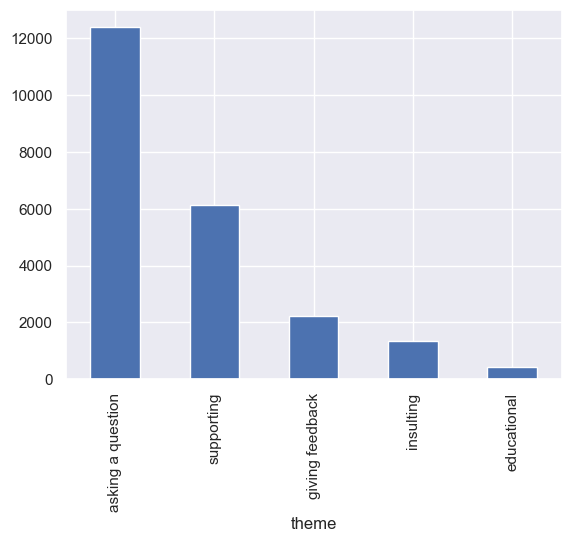

In [66]:
fig, ax = plt.subplots()
ax = df['theme'].value_counts().plot(kind='bar')

plt.show()